In [1]:
import copy
import numpy as np

import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
import torchvision.models as models

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class VGG(nn.Module):
    def __init__(self, output_dim):
        super().__init__()        
        self.features = models.vgg11_bn(weights=True).features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 8 * 8, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [3]:
OUTPUT_DIM = 2
model = VGG(OUTPUT_DIM)
print(model)

d:\anaconda3\envs\torch_book\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [4]:
train_transforms = transforms.Compose([
                           transforms.Resize((256, 256)),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
                           transforms.Resize((256, 256)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [5]:
train_path = 'data/catanddog/train'
test_path = 'data/catanddog/test'

train_dataset = torchvision.datasets.ImageFolder(
    train_path,
    transform=train_transforms
)

test_dataset = torchvision.datasets.ImageFolder(
    test_path,
    transform=test_transforms
)

print(len(train_dataset)), print(len(test_dataset))

529
107


(None, None)

In [6]:
VALID_RATIO = 0.9
n_train_examples = int(len(train_dataset) * VALID_RATIO)
n_valid_examples = len(train_dataset) - n_train_examples

train_data, valid_data = data.random_split(train_dataset, 
                                           [n_train_examples, n_valid_examples])

In [7]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 476
Number of validation examples: 53
Number of testing examples: 107


In [9]:
BATCH_SIZE = 32
train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_dataset, 
                                batch_size = BATCH_SIZE)

In [10]:
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-5)      # ! optimizer for classifier only ! not for features(pre-trained)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [11]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [12]:
def train(model, iterator, optimizer, criterion, device):    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()    
    for (x, y) in iterator:        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()                
        y_pred, _ = model(x)        
        loss = criterion(y_pred, y)       
        acc = calculate_accuracy(y_pred, y)        
        loss.backward()        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [13]:
def evaluate(model, iterator, criterion, device):    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()    
    with torch.no_grad():        
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [14]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [15]:
EPOCHS = 5
best_valid_loss = float('inf')
train_losses = []
valid_losses = []

for epoch in range(EPOCHS):    
    start_time = time.monotonic()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'data/VGG-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Valid. Loss: {valid_loss:.3f} |  Valid. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 56s
	Train Loss: 0.651 | Train Acc: 69.91%
	 Valid. Loss: 0.590 |  Valid. Acc: 91.29%
Epoch: 02 | Epoch Time: 0m 12s
	Train Loss: 0.529 | Train Acc: 93.30%
	 Valid. Loss: 0.464 |  Valid. Acc: 91.29%
Epoch: 03 | Epoch Time: 0m 9s
	Train Loss: 0.381 | Train Acc: 96.25%
	 Valid. Loss: 0.321 |  Valid. Acc: 91.29%
Epoch: 04 | Epoch Time: 0m 9s
	Train Loss: 0.243 | Train Acc: 96.04%
	 Valid. Loss: 0.231 |  Valid. Acc: 91.29%
Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 0.154 | Train Acc: 97.26%
	 Valid. Loss: 0.157 |  Valid. Acc: 98.44%


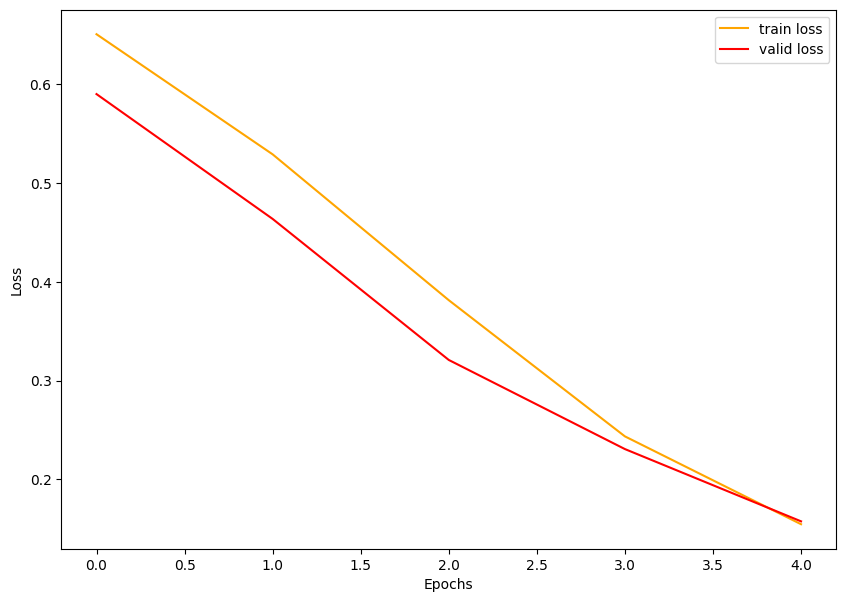

In [16]:
plt.figure(figsize = (10, 7))
plt.plot(train_losses, color = 'orange', label = 'train loss')
plt.plot(valid_losses, color = 'red', label = 'valid loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
def get_predictions(model, iterator):
    model.eval()
    images = []
    labels = []
    probs = []
    
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    return images, labels, probs

In [18]:
images, labels, probs = get_predictions(model, test_iterator)
pred_labels = torch.argmax(probs, 1)
corrects = torch.eq(labels, pred_labels)
correct_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if correct:
        correct_examples.append((image, label, prob))

correct_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [19]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [20]:
def plot_most_correct(correct, classes, n_images, normalize = True):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize = (25, 20))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)        
        image, true_label, probs = correct[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        correct_prob, correct_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        correct_class = classes[correct_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {correct_class} ({correct_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.4)

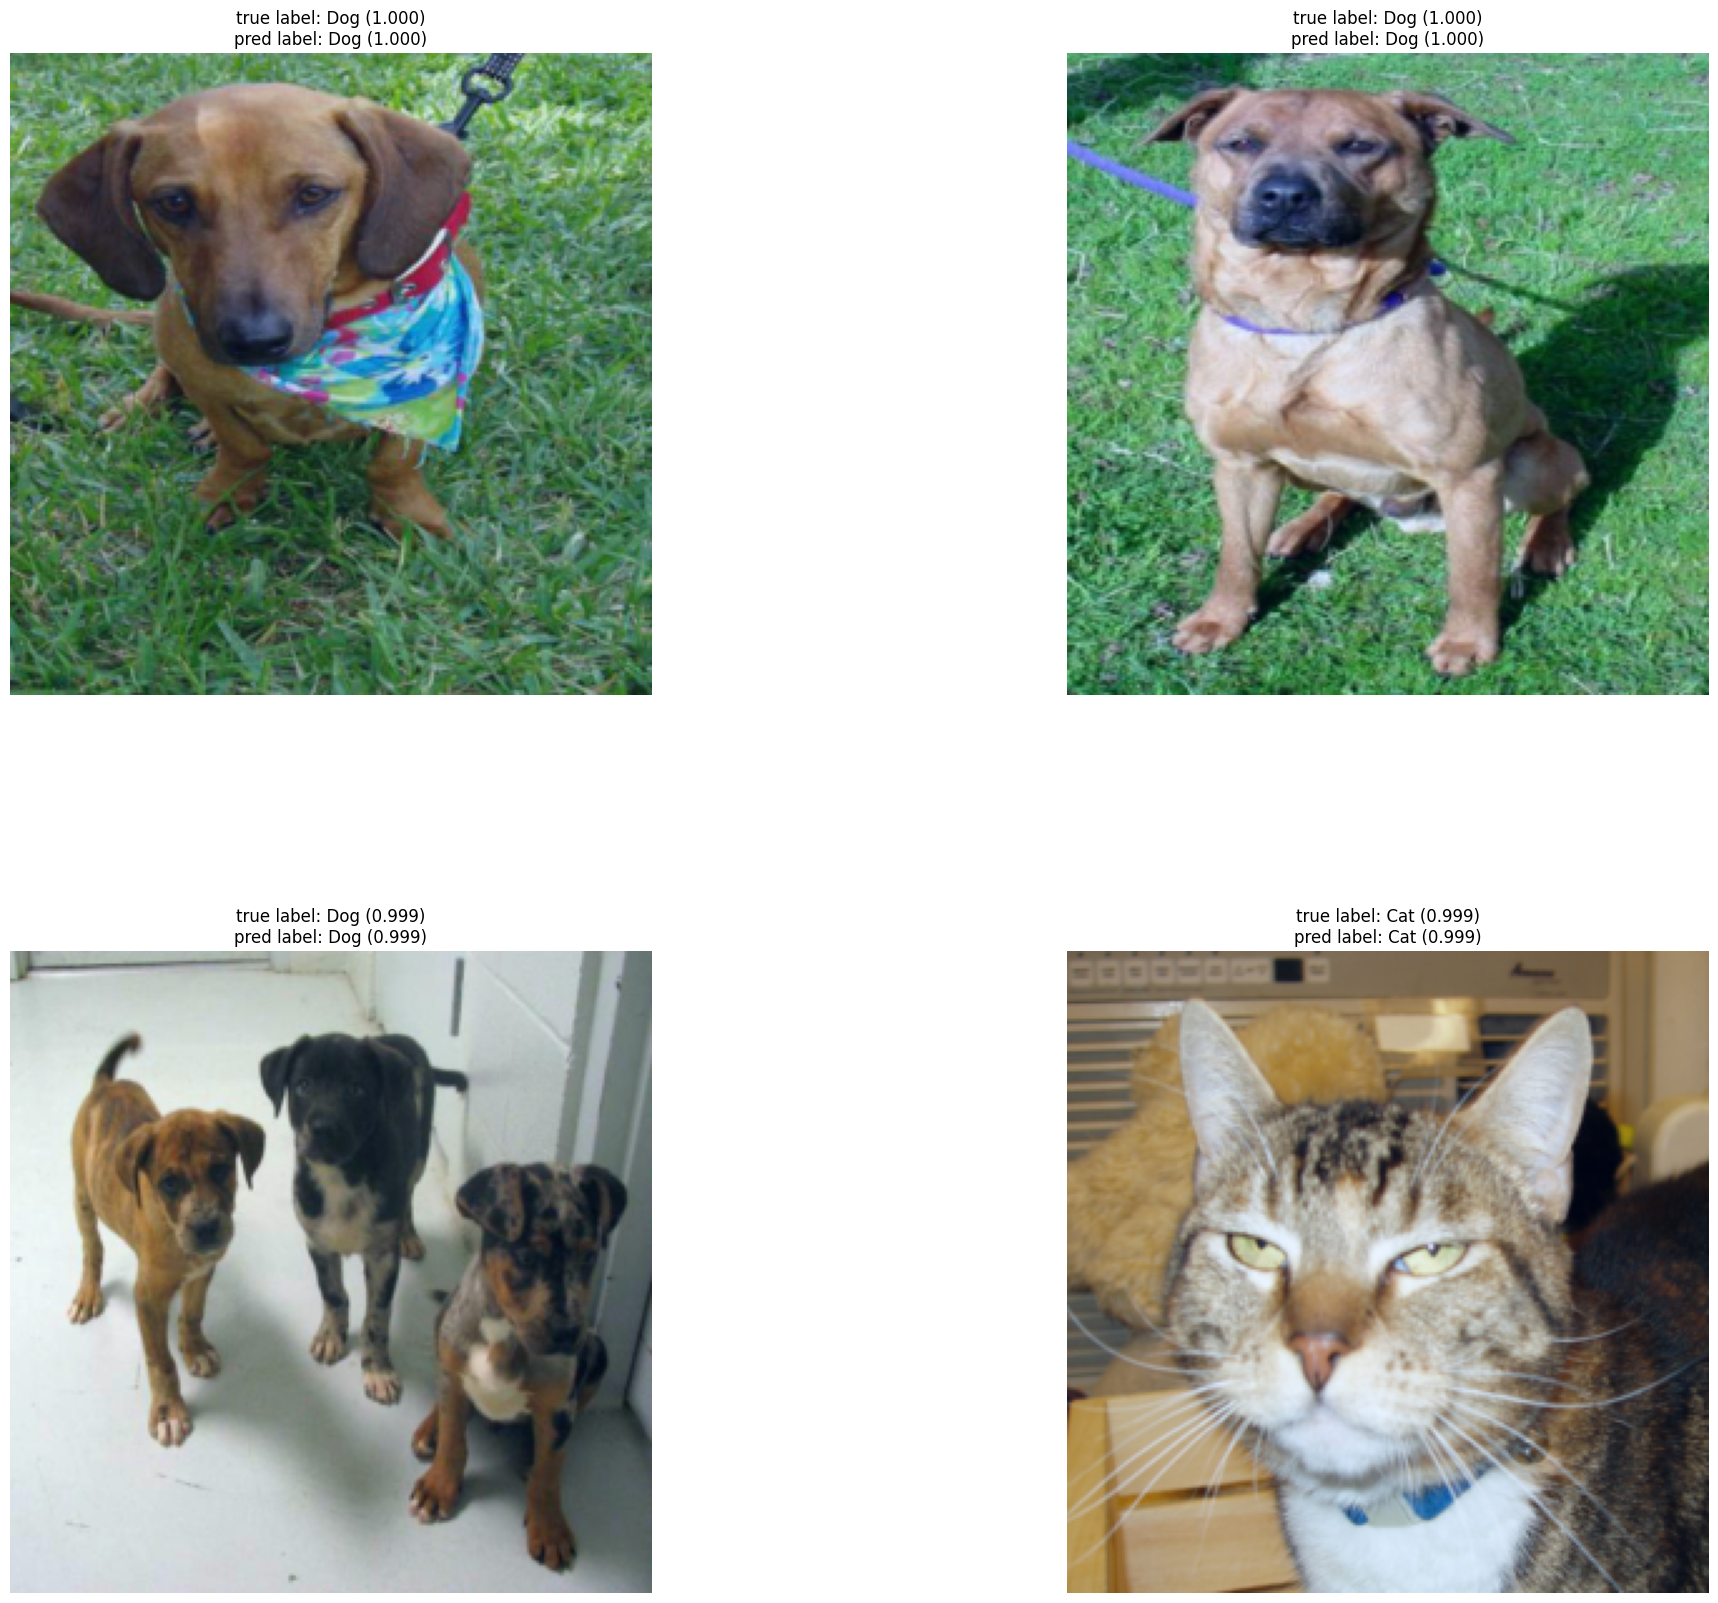

In [21]:
classes = test_dataset.classes
N_IMAGES = 5
plot_most_correct(correct_examples, classes, N_IMAGES)